<a href="https://colab.research.google.com/github/mofuoku417/Machine-Learning-Techniques-for-Multivariate-Time-Series-Forecasting-of-Crude-Palm-Oil-Prices/blob/main/MV_MLP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Load the Libraries

In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (10, 5)
plt.style.use('fivethirtyeight')
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

import matplotlib.dates as mdates
from sklearn.preprocessing import RobustScaler

###Define Functions to Facilitate Metrics Evaluation

In [123]:
#To compute Mean Directional Accuracy
def mda(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])).astype(int))

#Calculate the Mean Absolute Percentage Error
#def MAPE(y_true, y_pred): 
    #mape = np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / np.array(y_true))) * 100
    #return mape

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#Calculate the Root Mean Squared Error:
def RMSE(y_true, y_pred): 
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

###Load the Cleaned Data from Github

In [124]:
from pandas import read_csv
path = 'https://raw.githubusercontent.com/mofuoku417/multivariate-time-series-prediction-of-crude-palm-oil-price-data-science-approach/main/cleaned_data/preprocessed.csv'
df = read_csv(path, index_col=0)
df.head()

,Date,cpo_pri,cno_pri,rps_pri,pno_pri,sbo_pri,wti_spri
0,2002-02-01,323.0,455.0,423.45,844.0,468.0,28.67
1,2002-03-01,345.0,546.0,415.85,799.0,485.0,24.49
2,2002-04-01,362.0,595.0,410.77,718.0,466.0,22.06
3,2002-05-01,376.0,636.0,414.82,614.0,442.0,21.64
4,2002-06-01,383.0,738.0,451.04,619.0,429.0,22.30


In [125]:
df.index = pd.to_datetime(df['Date'], format='%Y.%m.%d')
del df['Date']

In [126]:
df.head()

,cpo_pri,cno_pri,rps_pri,pno_pri,sbo_pri,wti_spri
Date,,,,,,
2002-02-01,323.0,455.0,423.45,844.0,468.0,28.67
2002-03-01,345.0,546.0,415.85,799.0,485.0,24.49
2002-04-01,362.0,595.0,410.77,718.0,466.0,22.06
2002-05-01,376.0,636.0,414.82,614.0,442.0,21.64
2002-06-01,383.0,738.0,451.04,619.0,429.0,22.30


###Plot the Target Variable

Text(0.5, 0, 'Date')

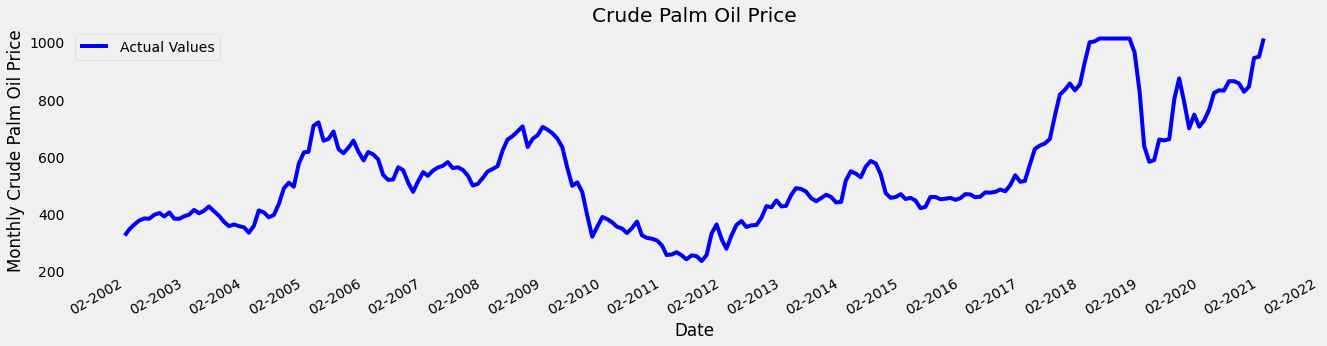

In [127]:
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(df.index, df['cpo_pri'], color = 'blue',  label = 'Test')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.gcf().autofmt_xdate() # Rotation
plt.legend(['Actual Values', 'Crude Palm Oil Price 2002-2021'],loc='best')
plt.title('Crude Palm Oil Price')
plt.ylabel('Monthly Crude Palm Oil Price')
plt.xlabel('Date')

###Visualize Multiple Time Series

In [128]:
fig = make_subplots(rows=6, cols=1)
fig.add_trace(
    go.Scatter(x=df.reset_index()['Date'], y=df.reset_index()['cpo_pri'],name='crude palm oil price'),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=df.reset_index()['Date'], y=df.reset_index()['cno_pri'],name='coconut oil price'),
    row=2, col=1
)
fig.add_trace(
    go.Scatter(x=df.reset_index()['Date'], y=df.reset_index()['rps_pri'],name='rapeseed oil price'),
    row=3, col=1
)
fig.add_trace(
    go.Scatter(x=df.reset_index()['Date'], y=df.reset_index()['pno_pri'],name='peanut oil price'),
    row=4, col=1
)
fig.add_trace(
    go.Scatter(x=df.reset_index()['Date'], y=df.reset_index()['sbo_pri'],name='soybean oil price'),
    row=4, col=1
)
fig.add_trace(
    go.Scatter(x=df.reset_index()['Date'], y=df.reset_index()['wti_spri'],name='west texas intermediate spot price'),
    row=4, col=1

)
fig.update_layout(height=1000, width=1200, title_text="Time Series")
fig.show()

<Figure size 1800x720 with 0 Axes>

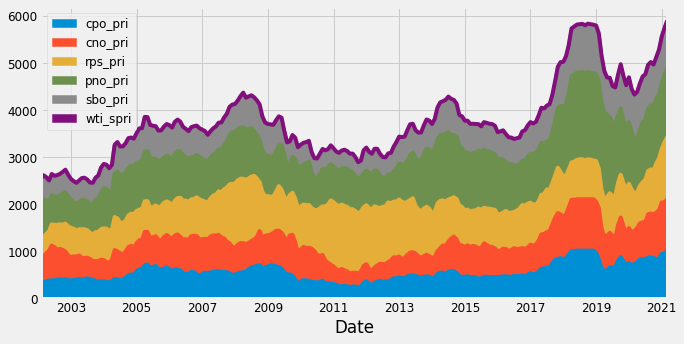

In [129]:
# Plot an area chart
plt.figure(figsize=(25,10))
ax = df.plot.area(fontsize=12);

# Additional customizations
ax.set_xlabel('Date');
ax.legend(fontsize=12);

##**Multilayer Forecasting Technique (MLP)**

###**Split Data into Train Test Segments**

In [130]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print('Train size:',len(train))
print('Test size:', len(test))

Train size: 184
Test size: 46


In [131]:
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

184 46


In [132]:
print(train.shape)
train.head()

(184, 6)


,cpo_pri,cno_pri,rps_pri,pno_pri,sbo_pri,wti_spri
Date,,,,,,
2002-02-01,323.0,455.0,423.45,844.0,468.0,28.67
2002-03-01,345.0,546.0,415.85,799.0,485.0,24.49
2002-04-01,362.0,595.0,410.77,718.0,466.0,22.06
2002-05-01,376.0,636.0,414.82,614.0,442.0,21.64
2002-06-01,383.0,738.0,451.04,619.0,429.0,22.30


###Rescale train dataset

In [133]:
f_transformer = RobustScaler()
feature_columns = ['cpo_pri','cno_pri', 'rps_pri', 'pno_pri', 'sbo_pri', 'wti_spri']
f_transformer = f_transformer.fit(train[feature_columns].to_numpy())
train.loc[:, feature_columns] = f_transformer.transform(train[feature_columns].to_numpy())
train.head()

,cpo_pri,cno_pri,rps_pri,pno_pri,sbo_pri,wti_spri
Date,,,,,,
2002-02-01,-0.801187,-0.646119,-1.324544,-0.231262,-0.442244,-0.717978
2002-03-01,-0.670623,-0.230594,-1.348516,-0.395149,-0.338987,-0.856057
2002-04-01,-0.569733,-0.006849,-1.364539,-0.690145,-0.454392,-0.936328
2002-05-01,-0.486647,0.180365,-1.351764,-1.068905,-0.600167,-0.950202
2002-06-01,-0.445104,0.646119,-1.237519,-1.050696,-0.679128,-0.928400


In [134]:
cpo_pri_transformer = RobustScaler()
cpo_pri_transformer = cpo_pri_transformer.fit(train[['cpo_pri']])
train['cpo_pri'] = cpo_pri_transformer.transform(train[['cpo_pri']])
train['cpo_pri'].head()

Date
2002-02-01   -0.801187
2002-03-01   -0.670623
2002-04-01   -0.569733
2002-05-01   -0.486647
2002-06-01   -0.445104
Name: cpo_pri, dtype: float64

In [135]:
test.loc[:, feature_columns] = f_transformer.transform(test[feature_columns].to_numpy())
test.head()

,cpo_pri,cno_pri,rps_pri,pno_pri,sbo_pri,wti_spri
Date,,,,,,
2017-06-01,1.068249,0.614155,0.012901,0.597786,0.950695,-0.031877
2017-07-01,1.109792,0.760274,0.197485,0.396351,1.058264,-0.007763
2017-08-01,1.204748,0.787671,0.100871,0.537949,1.082499,-0.131968
2017-09-01,1.691395,1.057078,0.093017,0.621567,1.293083,-0.091007
2017-10-01,2.124629,1.358447,0.169917,0.953857,1.505672,-0.215212


In [136]:
test['cpo_pri'] = cpo_pri_transformer.transform(test[['cpo_pri']])
test['cpo_pri'].head()

Date
2017-06-01    1.068249
2017-07-01    1.109792
2017-08-01    1.204748
2017-09-01    1.691395
2017-10-01    2.124629
Name: cpo_pri, dtype: float64

###Create X_train, y_train, X_test and y_test

In [137]:
def createDataset(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        data = X.iloc[i:(i + time_steps)].values
        Xs.append(data)        
        ys.append(y.iloc[i + time_steps])
        
    return np.array(Xs), np.array(ys)

time_steps = 3
X_train, y_train = createDataset(train, train.cpo_pri, time_steps)
X_test, y_test = createDataset(test, test.cpo_pri, time_steps)
print(X_train.shape, y_train.shape)

(181, 3, 6) (181,)


###Create Model

####Declare input shape

In [138]:
X_train_mlp = X_train[:, :, 0]
X_test_mlp = X_test[:, :, 0]
mlp_model = tf.keras.Sequential()
mlp_model.add(tf.keras.layers.Dense(128, input_dim=X_train.shape[1], activation='relu'))
mlp_model.add(tf.keras.layers.Dense(1))

###Compile the model

In [139]:
mlp_model.compile(loss='mse', optimizer='adam')
mlp_model

###Train the model

In [140]:
history = mlp_model.fit(
    X_train_mlp, y_train, 
    epochs=100, 
    batch_size=32, 
    validation_split=0.1,
    shuffle=False
)

Epoch 1/100
6/6 [==============================] - 1s 114ms/step - loss: 0.4266 - val_loss: 0.0723
Epoch 2/100
6/6 [==============================] - 0s 9ms/step - loss: 0.3178 - val_loss: 0.0587
Epoch 3/100
6/6 [==============================] - 0s 11ms/step - loss: 0.2362 - val_loss: 0.0476
Epoch 4/100
6/6 [==============================] - 0s 13ms/step - loss: 0.1731 - val_loss: 0.0388
Epoch 5/100
6/6 [==============================] - 0s 10ms/step - loss: 0.1266 - val_loss: 0.0319
Epoch 6/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0944 - val_loss: 0.0268
Epoch 7/100
6/6 [==============================] - 0s 12ms/step - loss: 0.0739 - val_loss: 0.0234
Epoch 8/100
6/6 [==============================] - 0s 12ms/step - loss: 0.0622 - val_loss: 0.0212
Epoch 9/100
6/6 [==============================] - 0s 12ms/step - loss: 0.0560 - val_loss: 0.0199
Epoch 10/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0530 - val_loss: 0.0192
Epoch 11/100
6/6 [=

###Model Summary

In [141]:
mlp_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 128)               512       
                                                                 
 dense_17 (Dense)            (None, 1)                 129       
                                                                 
Total params: 641
Trainable params: 641
Non-trainable params: 0
_________________________________________________________________


###Predict the test data

In [142]:
y_pred = mlp_model.predict(X_test_mlp)
y_pred

array([[1.1623837 ],
       [1.6614618 ],
       [2.0103714 ],
       [2.033488  ],
       [2.1500742 ],
       [1.9814544 ],
       [2.1408138 ],
       [2.5603783 ],
       [2.9257367 ],
       [2.8821843 ],
       [2.9327927 ],
       [2.9214532 ],
       [2.9245908 ],
       [2.9245908 ],
       [2.9245908 ],
       [2.9245908 ],
       [2.9245908 ],
       [2.6585555 ],
       [1.9418153 ],
       [0.99204946],
       [0.7720654 ],
       [0.7544354 ],
       [1.2304914 ],
       [1.1066346 ],
       [1.1423253 ],
       [2.022836  ],
       [2.2904265 ],
       [1.7574096 ],
       [1.2626543 ],
       [1.645133  ],
       [1.3238299 ],
       [1.4983658 ],
       [1.7037768 ],
       [2.0227823 ],
       [2.0151312 ],
       [1.9996645 ],
       [2.2022083 ],
       [2.1672304 ],
       [2.1192157 ],
       [1.949857  ],
       [2.098943  ],
       [2.6803415 ],
       [2.6246412 ]], dtype=float32)

###Inverse transformed data

Scale the data back to the original representation

In [143]:
y_train_inv = cpo_pri_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cpo_pri_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cpo_pri_transformer.inverse_transform(y_pred)
print(y_train_inv)
print(y_test_inv)
print(y_pred_inv)

[[-0.48664688 -0.44510386 -0.45103858 -0.36795252 -0.33234421 -0.40356083
  -0.32047478 -0.45103858 -0.45103858 -0.39762611 -0.36795252 -0.26706231
  -0.33827893 -0.28486647 -0.1958457  -0.29673591 -0.39169139 -0.51632047
  -0.60534125 -0.56973294 -0.60534125 -0.62908012 -0.74183976 -0.59940653
  -0.27893175 -0.32047478 -0.42136499 -0.37388724 -0.14243323  0.17804154
   0.29673591  0.21364985  0.69436202  0.92581602  0.93768546  1.47774481
   1.54896142  1.16913947  1.20474777  1.35905045  0.99109792  0.90801187
   1.02670623  1.16913947  0.93768546  0.75964392  0.93175074  0.884273
   0.78338279  0.45697329  0.35608309  0.3620178   0.61721068  0.5578635
   0.29673591  0.10682493  0.3264095   0.51632047  0.43916914  0.54599407
   0.61127596  0.64688427  0.72403561  0.59940653  0.61721068  0.56379822
   0.44510386  0.23738872  0.27299703  0.39762611  0.52818991  0.58160237
   0.64094955  0.96735905  1.19287834  1.26409496  1.36498516  1.46587537
   1.03857567  1.20474777  1.28189911  1.

###Plot history, actual and predicted value

In [146]:
y_train_inv = y_train_inv.flatten()
y_train_inv
y_test_inv = y_test_inv.flatten()
y_test_inv

array([1.69139466, 2.12462908, 2.22551929, 2.35608309, 2.21364985,
       2.33827893, 2.77744807, 3.21068249, 3.22848665, 3.28931751,
       3.28931751, 3.28931751, 3.28931751, 3.28931751, 3.28931751,
       3.28931751, 3.00296736, 2.18397626, 1.05637982, 0.72997033,
       0.76557864, 1.19287834, 1.17507418, 1.19881306, 2.02967359,
       2.46290801, 1.96439169, 1.42433234, 1.70919881, 1.45994065,
       1.58456973, 1.81008902, 2.16023739, 2.21364985, 2.20771513,
       2.40356083, 2.40356083, 2.35608309, 2.18397626, 2.29080119,
       2.884273  , 2.91394659, 3.28931751])

In [147]:
y_pred_inv = y_pred_inv.flatten()
y_pred_inv

array([1.1623837 , 1.6614618 , 2.0103714 , 2.033488  , 2.1500742 ,
       1.9814544 , 2.1408138 , 2.5603783 , 2.9257367 , 2.8821843 ,
       2.9327927 , 2.9214532 , 2.9245908 , 2.9245908 , 2.9245908 ,
       2.9245908 , 2.9245908 , 2.6585555 , 1.9418153 , 0.99204946,
       0.7720654 , 0.7544354 , 1.2304914 , 1.1066346 , 1.1423253 ,
       2.022836  , 2.2904265 , 1.7574096 , 1.2626543 , 1.645133  ,
       1.3238299 , 1.4983658 , 1.7037768 , 2.0227823 , 2.0151312 ,
       1.9996645 , 2.2022083 , 2.1672304 , 2.1192157 , 1.949857  ,
       2.098943  , 2.6803415 , 2.6246412 ], dtype=float32)

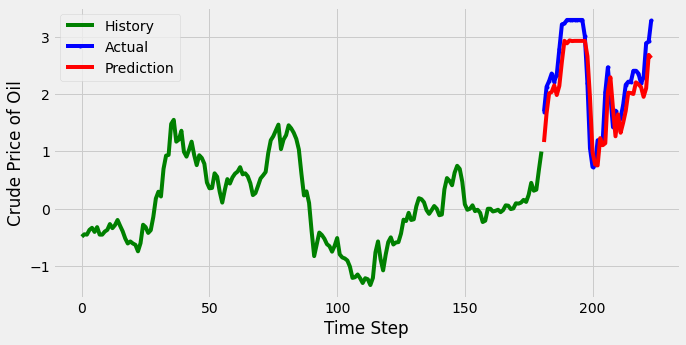

In [149]:
plt.plot(np.arange(0, len(y_train)), y_train_inv, color='green', label="History")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv, color='blue', marker='.', label="Actual")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv, color='red', label="Prediction")
plt.ylabel('Crude Price of Oil')
plt.xlabel('Time Step')
plt.legend()
plt.show();

###Plot actual and predicted value

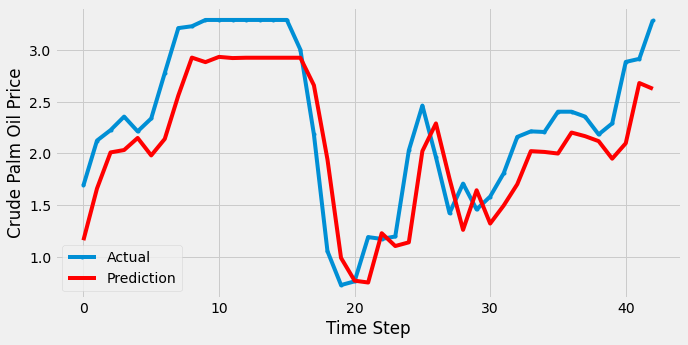

In [151]:
plt.plot(y_test_inv, marker='.', label="Actual")
plt.plot(y_pred_inv, color='red', label="Prediction")
plt.ylabel('Crude Palm Oil Price')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [ ]:
###########################################################################################################################################################

In [58]:
from sklearn.preprocessing import RobustScaler
f_columns = ['cno_pri', 'rps_pri', 'pno_pri', 'sbo_pri', 'wti_spri']

f_transformer = RobustScaler()
target_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())
target_transformer = target_transformer.fit(train[['cpo_pri']])

train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train['target'] = target_transformer.transform(train[['cpo_pri']])
###############################################################################################
'''
f_columns = ['t1', 't2', 'hum', 'wind_speed']

from sklearn.preprocessing import RobustScaler

f_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())

train.loc[:, f_columns] = f_transformer.transform(
  train[f_columns].to_numpy()
)

test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())

cpo_pri_transformer = RobustScaler()

cpo_pri_transformer = cpo_pri_transformer.fit(train[['cpo_pri']])

train['cpo_pri'] = cpo_pri_transformer.transform(train[['cpo_pri']])

test['cpo_pri'] = cpo_pri_transformer.transform(test[['cpo_pri']])
'''

In [59]:
train['target']

Date
2002-02-01   -0.781491
2002-03-01   -0.668380
2002-04-01   -0.580977
2002-05-01   -0.508997
2002-06-01   -0.473008
                ...   
2018-12-01    2.762211
2019-01-01    2.514139
2019-02-01    1.804627
2019-03-01    0.827763
2019-04-01    0.544987
Name: target, Length: 207, dtype: float64

In [60]:
train.head()

,cpo_pri,cno_pri,rps_pri,pno_pri,sbo_pri,wti_spri,target
Date,,,,,,,
2002-02-01,323.0,-0.706897,-1.632538,-0.361424,-0.461118,-0.835276,-0.781491
2002-03-01,345.0,-0.314655,-1.661990,-0.505341,-0.364340,-0.997669,-0.668380
2002-04-01,362.0,-0.103448,-1.681677,-0.764392,-0.472504,-1.092075,-0.580977
2002-05-01,376.0,0.073276,-1.665982,-1.097000,-0.609131,-1.108392,-0.508997
2002-06-01,383.0,0.512931,-1.525616,-1.081009,-0.683138,-1.082751,-0.473008


In [47]:
test.head()

,cpo_pri,cno_pri,rps_pri,pno_pri,sbo_pri,wti_spri
Date,,,,,,
2019-05-01,587.0,740.0,815.84,1761.69,745.55,43.02
2019-06-01,659.0,734.0,840.01,1619.87,789.89,45.12
2019-07-01,656.0,673.0,845.27,1543.24,747.64,48.41
2019-08-01,660.0,625.0,877.48,1535.22,730.71,51.45
2019-09-01,800.0,747.0,903.07,1433.00,809.08,56.83


In [61]:
print('Train shape:',train.shape)
print('Test shape:', test.shape)

Train shape: (207, 7)
Test shape: (23, 6)


In [62]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [63]:
time_steps = 3
# reshape to [samples, time_steps, features]
X_train, y_train = create_dataset(train, train.cpo_pri, time_steps)
X_test, y_test = create_dataset(test, test.cpo_pri, time_steps)
print(X_train.shape, y_train.shape)

(204, 3, 7) (204,)


In [64]:
# reshape to [samples, features]
X_train_mlp = X_train[:, :, 0]
X_test_mlp = X_test[:, :, 0]

mlp_model = tf.keras.Sequential()
mlp_model.add(tf.keras.layers.Dense(128, input_dim=X_train_mlp.shape[1], activation='relu'))
mlp_model.add(tf.keras.layers.Dense(1))
mlp_model.compile(loss='mse', optimizer='adam')
mlp_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               512       
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 641
Trainable params: 641
Non-trainable params: 0
_________________________________________________________________


In [65]:
mlp_history = mlp_model.fit(X_train_mlp, y_train, validation_data=(X_test_mlp, y_test), epochs=50, shuffle=False)

Epoch 1/50
7/7 [==============================] - 0s 21ms/step - loss: 198887.6250 - val_loss: 340853.1875
Epoch 2/50
7/7 [==============================] - 0s 5ms/step - loss: 107118.1016 - val_loss: 176159.9062
Epoch 3/50
7/7 [==============================] - 0s 6ms/step - loss: 48489.8086 - val_loss: 73260.5625
Epoch 4/50
7/7 [==============================] - 0s 5ms/step - loss: 16541.2832 - val_loss: 22465.9766
Epoch 5/50
7/7 [==============================] - 0s 5ms/step - loss: 4493.1289 - val_loss: 6177.1538
Epoch 6/50
7/7 [==============================] - 0s 5ms/step - loss: 2882.2480 - val_loss: 4546.1577
Epoch 7/50
7/7 [==============================] - 0s 5ms/step - loss: 3568.5894 - val_loss: 4718.1084
Epoch 8/50
7/7 [==============================] - 0s 5ms/step - loss: 3326.7849 - val_loss: 4488.1016
Epoch 9/50
7/7 [==============================] - 0s 11ms/step - loss: 2776.6162 - val_loss: 5067.9204
Epoch 10/50
7/7 [==============================] - 0s 15ms/step - lo

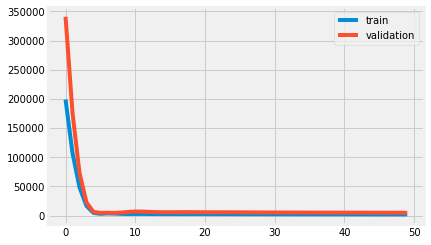

In [66]:
plt.plot(mlp_history.history['loss'], label='train')
plt.plot(mlp_history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [67]:
y_trai_inv = target_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = target_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = target_transformer.inverse_transform(y_pred)

In [68]:
y_test_inv, y_pred_inv

(array([[128845.   , 156075.   , 170273.5  , 153935.5  , 136236.   ,
         145572.   , 137403.   , 141487.5  , 148878.5  , 160354.   ,
         162104.5  , 161910.   , 168328.5  , 168328.5  , 166772.5  ,
         161132.   , 164633.   , 184083.   , 185055.5  , 197357.625]]),
 array([[124206.984],
        [127398.32 ],
        [143457.45 ],
        [156874.38 ],
        [156054.72 ],
        [145270.89 ],
        [144013.03 ],
        [137422.66 ],
        [140131.06 ],
        [143644.08 ],
        [152703.47 ],
        [157483.36 ],
        [160037.64 ],
        [164149.14 ],
        [165366.23 ],
        [165747.62 ],
        [162108.3  ],
        [162758.44 ],
        [173799.23 ],
        [178891.61 ]], dtype=float32))

In [55]:
y_test_inv/1000

array([[128.845   , 156.075   , 170.2735  , 153.9355  , 136.236   ,
        145.572   , 137.403   , 141.4875  , 148.8785  , 160.354   ,
        162.1045  , 161.91    , 168.3285  , 168.3285  , 166.7725  ,
        161.132   , 164.633   , 184.083   , 185.0555  , 197.357625]])

In [26]:
y_pred = mlp_model.predict(X_test_mlp)
y_train_inv = cpo_pri_scaler.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cpo_pri_scaler.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cpo_pri_scaler.inverse_transform(y_pred)

NameError: ignored

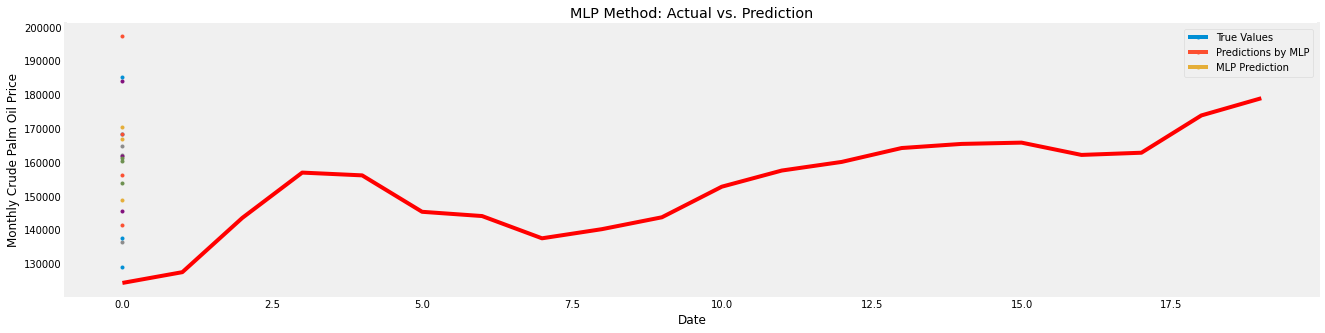

In [32]:
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(y_test_inv, marker='.', label='true')
plt.plot(y_pred_inv, 'r', label='predicted')
plt.legend(['True Values', 'Predictions by MLP', 'MLP Prediction'],loc='best')
plt.title('MLP Method: Actual vs. Prediction')
plt.ylabel('Monthly Crude Palm Oil Price')
plt.xlabel('Date')
plt.show()

###Model Evaluation

In [31]:
MAE_mlp = mean_absolute_error(y_test, y_pred_inv)
print('MAE value of the SVR Model is:', MAE_mlp)

MDA_mlp = mda(y_test, y_pred_inv)
print('MDA value of the SVR Model is:', MDA_mlp)

MAPE_mlp = mean_absolute_percentage_error(y_test, y_pred_inv)
print('MAPE value of the SVR Model is:', MAPE_mlp)

RMSE_mlp = mean_squared_error(y_test,y_pred_inv, squared=False)
print('RMSE value of the SVR Model is:', RMSE_mlp)

MSE_mlp = mean_squared_error(y_test,y_pred_inv)
print('MSE value of the SVR Model is:', MSE_mlp)

EVS_mlp = explained_variance_score(y_test, y_pred_inv)
print('EVS score of the MLP Model is:', EVS_mlp)

MAE value of the SVR Model is: 152256.068359375
MDA value of the SVR Model is: 0.5484764542936288
MAPE value of the SVR Model is: 18781.803275079823
RMSE value of the SVR Model is: 152909.83342697335
MSE value of the SVR Model is: 23381417158.664738
EVS score of the MLP Model is: -26494.511137984035


###**Adjusting Hyperparameters of MLP Regressor to get more perfect performance**
**Hyper Parameter Tuning:**

In [ ]:
mlp = MLPRegressor(max_iter=100)

In [ ]:
parameter_space = {
    'hidden_layer_sizes': [(64,64,64), (64,128,64), (128,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

In [ ]:
mlp_gs = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=5)
mlp_gs.fit(X_train_mlp , np.ravel(y_train))

ypred_grid = mlp_gs.predict(X_test_mlp)

print (np.c_[y_test, ypred_grid])
print('Best Parameters : ',mlp_gs.best_params_)
print('Best Score : ',mlp_gs.best_score_)

[[0.95115681 0.95943618]
 [1.67095116 0.9863523 ]
 [2.04627249 1.62752748]
 [1.61439589 2.00380522]
 [1.14652956 1.72028284]
 [1.3933162  1.23254332]
 [1.17737789 1.44723054]
 [1.28534704 1.24627534]
 [1.48071979 1.34132169]
 [1.7840617  1.5197456 ]
 [1.83033419 1.81350952]
 [1.8251928  1.91113537]
 [1.99485861 1.91906881]
 [1.99485861 2.07843597]
 [1.95372751 2.09261705]
 [1.80462725 2.05479744]
 [1.89717224 1.90731184]
 [2.41131105 1.98716629]
 [2.43701799 2.37506593]
 [2.7622108  2.49290323]]
Best Parameters :  {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (64, 128, 64), 'learning_rate': 'adaptive', 'solver': 'adam'}
Best Score :  0.8319281276150384


In [ ]:
mlpgs_model = tf.keras.Sequential()
# Adding the first MLP layer and activation
mlpgs_model.add(tf.keras.layers.Dense(64, input_dim=X_train_mlp.shape[1], activation='tanh'))
mlpgs_model.add(tf.keras.layers.LeakyReLU(alpha=0.0001))
 # Adding the second MLP layer and initializer
mlpgs_model.add(tf.keras.layers.Dense(128, kernel_initializer='random_normal'))
 # Adding the third MLP layer and initializer
mlpgs_model.add(tf.keras.layers.Dense(64, kernel_initializer='random_normal'))
mlpgs_model.add(tf.keras.layers.LeakyReLU(alpha=0.0001))
# Adding the output layer
mlpgs_model.add(tf.keras.layers.Dense(1))
mlpgs_model.compile(loss='mse', optimizer='adam')
mlpgs_model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_34 (Dense)            (None, 64)                256       
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 64)                0         
                                                                 
 dense_35 (Dense)            (None, 128)               8320      
                                                                 
 dense_36 (Dense)            (None, 64)                8256      
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 64)                0         
                                                                 
 dense_37 (Dense)            (None, 1)                 65        
                                                                 
Total params: 16,897
Trainable params: 16,897
Non-tra

In [ ]:
mlpgs_history = mlpgs_model.fit(X_train_mlp, y_train, validation_data=(X_test_mlp, y_test), epochs=100, shuffle=False)

Epoch 1/100
7/7 [==============================] - 1s 24ms/step - loss: 0.6549 - val_loss: 2.2827
Epoch 2/100
7/7 [==============================] - 0s 7ms/step - loss: 0.3988 - val_loss: 1.3922
Epoch 3/100
7/7 [==============================] - 0s 6ms/step - loss: 0.1836 - val_loss: 0.5456
Epoch 4/100
7/7 [==============================] - 0s 5ms/step - loss: 0.0701 - val_loss: 0.1249
Epoch 5/100
7/7 [==============================] - 0s 6ms/step - loss: 0.0919 - val_loss: 0.1269
Epoch 6/100
7/7 [==============================] - 0s 5ms/step - loss: 0.0862 - val_loss: 0.1060
Epoch 7/100
7/7 [==============================] - 0s 6ms/step - loss: 0.0676 - val_loss: 0.1502
Epoch 8/100
7/7 [==============================] - 0s 6ms/step - loss: 0.0537 - val_loss: 0.1213
Epoch 9/100
7/7 [==============================] - 0s 6ms/step - loss: 0.0455 - val_loss: 0.0941
Epoch 10/100
7/7 [==============================] - 0s 5ms/step - loss: 0.0433 - val_loss: 0.0952
Epoch 11/100
7/7 [==========

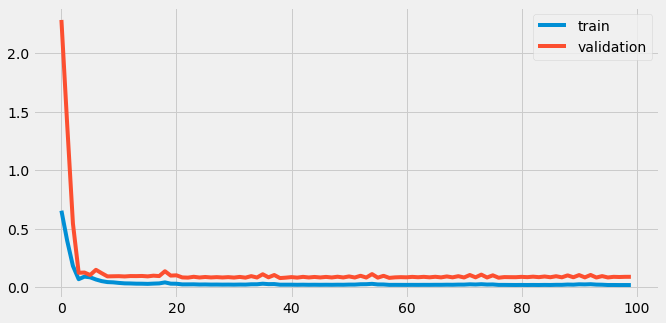

In [ ]:
plt.plot(mlpgs_history.history['loss'], label='train')
plt.plot(mlpgs_history.history['val_loss'], label='validation')
plt.legend()
plt.show()

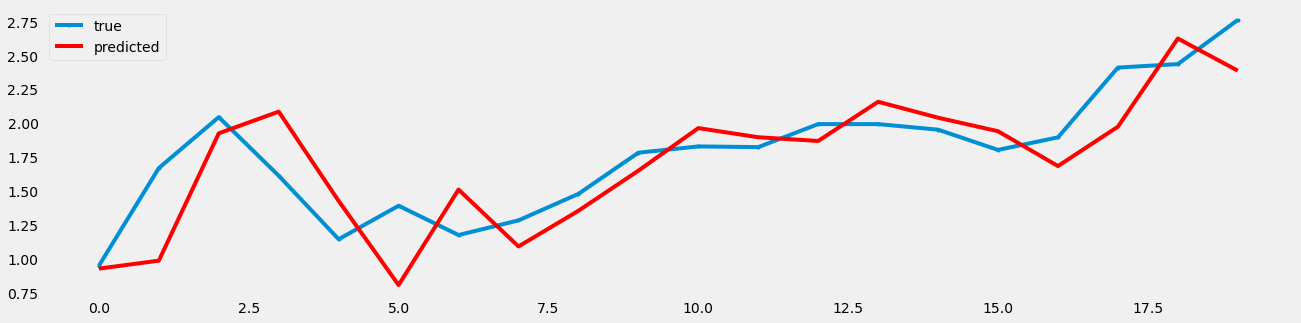

In [ ]:
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(y_test_inv.flatten(), marker='.', label='true')
plt.plot(y_pred_inv.flatten(), 'r', label='predicted')
plt.legend()
plt.show()

In [ ]:
MAE_mlp = mean_absolute_error(y_test, y_pred_inv)
print('MAE value of the SVR Model is:', MAE_mlp)

MDA_mlp = mda(y_test, y_pred_inv)
print('MDA value of the SVR Model is:', MDA_mlp)

MAPE_mlp = mean_absolute_percentage_error(y_test, y_pred_inv)
print('MAPE value of the SVR Model is:', MAPE_mlp)

RMSE_mlp = mean_squared_error(y_test,y_pred_inv, squared=False)
print('RMSE value of the SVR Model is:', RMSE_mlp)

MSE_mlp = mean_squared_error(y_test,y_pred_inv)
print('MSE value of the SVR Model is:', MSE_mlp)

EVS_mlp = explained_variance_score(y_test, y_pred_inv)
print('EVS score of the MLP Model is:', EVS_mlp)

MAE value of the SVR Model is: 0.2438652180614079
MDA value of the SVR Model is: 0.481994459833795
MAPE value of the SVR Model is: 32.026284717934395
RMSE value of the SVR Model is: 0.3007638860319343
MSE value of the SVR Model is: 0.09045891514103037
EVS score of the MLP Model is: 0.561476550442612
